In [17]:
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.fftpack import fft, ifft 
import sys
sys.path.append('/Users/zhangkewen/Documents/scripts/voltagecalculate_1125')
import AiresInfoFunctions as Aires

In [44]:
#direction of magnetic field, same for this dataset
Inclination =62.27 
Declination=0
Inclination = Inclination*np.pi/180+np.pi/2
Bx = np.cos(Declination) * np.sin(Inclination)
By = np.sin(Declination) * np.sin(Inclination)
Bz = np.cos(Inclination)

In [26]:
#the ZHAires simulation I use has sampling rate of 0.5ns and 1999 data points
#it should be extend to 2000 data points to match with sampling rate
#here I use the Plancherel theorem and calculate the energy fluence in freqeuncy domain
#considering half of the signals, since the other half is symmetric
#vacuume permitivity constance and speed of light neglected
def get_fluence(trace):
    return sum(abs(trace) ** 2) / 1000


    

In [40]:
def get_shower(dir_):
    ids, x, y, z = np.loadtxt(dir_ + '/antpos.dat', usecols=[0, 2, 3, 4]).T
    x_trig = np.array([])
    y_trig = np.array([])
    z_trig = np.array([])
    Esq = np.array([])
    for ant in range(176):
        tracef = dir_ + dir_.split('/')[-2] + '/a' + str(ant) + '.trace'
        t,ex,ey,ez=np.loadtxt(tracef).T
        ex=np.append(0,ex)
        ey=np.append(0,ey)
        ez=np.append(0,ez)
        Edata_fft=np.array([fft(ex),fft(ey),fft(ez)]).T
        #only consiering signal in 50-200MHz and converting unit from muV/m to V/m
        e_mag_fft = np.sqrt(abs(Edata_fft[49:200, 0] * 1e-6) ** 2 + abs(Edata_fft[49:200, 1] * 1e-6) ** 2 + abs(
            Edata_fft[49:200, 2] * 1e-6) ** 2)
        e_fluence = get_fluence(e_mag_fft)
        E_filter_t_mag = np.sqrt(abs(Edata_fft[49:200, 0] * 1e-6) ** 2 + abs(Edata_fft[49:200, 1] * 1e-6) ** 2 + abs(
            Edata_fft[49:200, 2] * 1e-6) ** 2)*2
        Esq = np.append(Esq, e_fluence)
    return x,y,z,Esq


In [46]:
pathdir='/Users/zhangkewen/Documents/scripts/voltagecalculate_1125/test/Stshp_MZS_QGS204JET_Proton_0.21_79.6_90.0_8/'
x_pos,y_pos,z_pos,Esq=get_shower(pathdir)


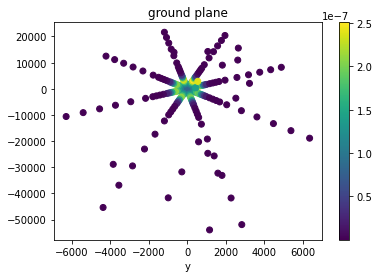

In [60]:
plt.scatter(x_trig,y_trig,c=Esq)
plt.xlabel('x')
plt.xlabel('y')
plt.title('ground plane')
plt.colorbar()

In [41]:
def get_rProj(pos_, k_, core_decay_, _B):
    #The position of the antenna in the shower plane
    _pos = (pos_ - core_decay_).T
    _kxB = np.cross(k_,_B)
    _kxB /= np.linalg.norm(_kxB)
    _kxkxB = np.cross(k_,_kxB)
    _kxkxB /= np.linalg.norm(_kxkxB)
    return np.array([np.dot(_kxB, _pos), np.dot(_kxkxB, _pos), np.dot(k_, _pos)])

In [58]:
#direction in grand coordinate
zenith=(180-79.6)*np.pi/180
azimuth=270*np.pi/180
k_shower = np.array([np.sin(zenith) * np.cos(azimuth), np.sin(zenith) * np.sin(azimuth), np.cos(zenith)])
B_field=np.array([Bx,By,Bz])
#core at (0,0) but with ground altitude of 2100m, same in this dataset
#you can read zenith, azimuth, ground altitude, etc. shower parameters in sry file, but here I don't use it
x_sp,y_sp,_=get_rProj(np.array([x_pos,y_pos,z_pos]).T,k_shower,np.array([0,0,2100]),B_field)

Text(0, 0.5, 'sum(E^2)')

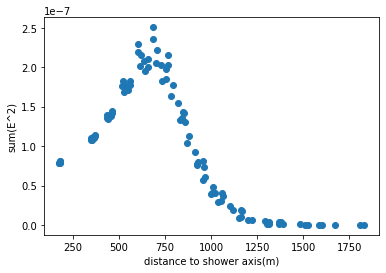

In [62]:
#data points larger than 100 are very small, giving a flat tail
plt.scatter(np.sqrt(x_sp[0:100]**2+y_sp[0:100]**2),Esq[0:100])
plt.xlabel('distance to shower axis(m)')
plt.ylabel('sum(E^2)')